In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
import gp_lens
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
redshift_list = ('05', '10', '15', '20', '25')

In [29]:
peaks = gp_lens.LensingPSorPeaks(-0.01, 1000, 'KN', redshifts=redshift_list, observable_name='Peaks', bin_center_row=0, smoothing='2.00')
x, y = peaks.get_realizations(model_index=1, verbose=True)
peaks.fid = np.mean(y,axis=0)

powerspec = gp_lens.LensingPSorPeaks(300,5000, 'KN', redshifts=redshift_list, observable_name='PS', bin_center_row=0, binscale='log')
x, y = powerspec.get_realizations(model_index=0, verbose=True)
powerspec.fid = np.mean(y,axis=0)

/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps05/Peaks_KN_s2.00_z0.50_ng08.83_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps10/Peaks_KN_s2.00_z1.00_ng13.25_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps15/Peaks_KN_s2.00_z1.50_ng11.15_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps20/Peaks_KN_s2.00_z2.00_ng07.36_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps25/Peaks_KN_s2.00_z2.50_ng04.26_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995/box1/Maps05/PS_KN_s1.00_z0.50_ng08.83

In [38]:
class LensingPS_AND_Peaks(gp_lens.LensingPSorPeaks):
    def __init__(self, sky_coverage=1e4):
        """Initialize the parameters table and specifications."""
        # read in list of simulation cosmo parameters
        self.table = Table.read('parameters.table', format='ascii')
        
        # dictionary for getting the appropriate ng for a redshift
        self.ng_dict = {
            '05': '08.83',
            '10': '13.25',
            '15': '11.15',
            '20': '07.36',
            '25': '04.26',
            '10_ng40': '40.00'
        }
        self.sky_coverage = sky_coverage
        
        self.params = np.array([self.table['M_nu(eV)'],
                                self.table['Omega_m'],
                                self.table['10^9*A_s']])
        
    def get_realizations(self, model_index, covariance=False, verbose=False):
        x_peaks, y_peaks = peaks.get_realizations(model_index, covariance, verbose)
        x_ps, y_ps = powerspec.get_realizations(model_index, covariance, verbose)
        
        print(len(x_peaks), len(x_ps))
        
        return np.hstack([x_ps, x_peaks]), np.hstack([y_ps, y_peaks])

In [39]:
combo = LensingPS_AND_Peaks()

In [40]:
x, y = combo.get_realizations(model_index=1, verbose=True)
combo.fid = np.mean(y,axis=0)

/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps05/Peaks_KN_s2.00_z0.50_ng08.83_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps10/Peaks_KN_s2.00_z1.00_ng13.25_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps15/Peaks_KN_s2.00_z1.50_ng11.15_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps20/Peaks_KN_s2.00_z2.00_ng07.36_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps25/Peaks_KN_s2.00_z2.50_ng04.26_b050.npy
[41, 42, 42, 41, 40]
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps05/PS_KN_s1.

In [33]:
cov = np.linalg.inv(combo.compute_cov(0) )

(9999, 326)


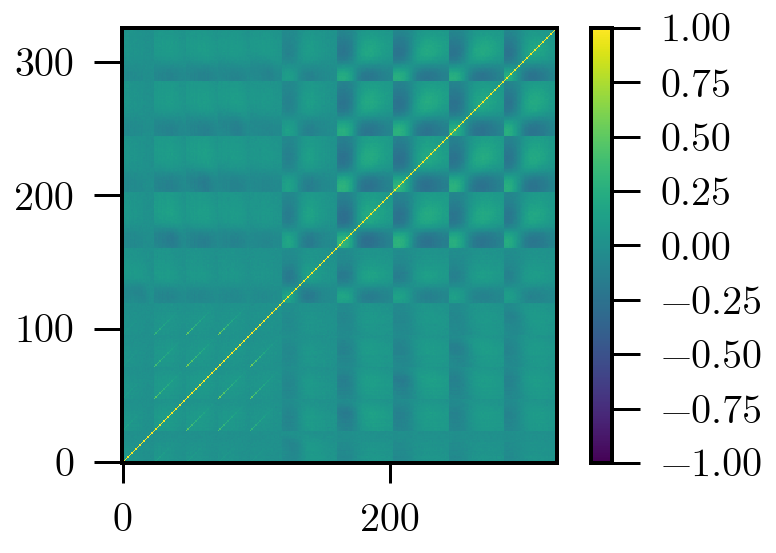

In [34]:
nbin = cov.shape[0]
Rij = np.zeros((nbin,nbin))
for i in range(nbin):
    for j in range(nbin):
        Rij[i,j] = cov[i,j] / np.sqrt(cov[i,i] * cov[j,j])
        
plt.imshow(Rij, vmin=-1, vmax=1, origin="lower")
plt.colorbar()
plt.savefig("figures/mega_cov_noisy.pdf")

In [9]:
index_list = np.arange(len(peaks.params.T))
index_list = np.delete(index_list, 0)
index_list = np.delete(index_list, 0)

modified_y = [combo.get_realizations(i) for i in index_list]
modified_X = (combo.params.T[index_list]).T

combo.fit(X=modified_X, real_list=modified_y)

/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 2.41188682e-05,  2.85291267e-05, -3.25777891e-04, -5.23197466e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 21, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 3.19891988e-05, -6.15095586e-05,  1.16434273e-04, -3.38198894e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 15, 'warnflag': 2}
  " state: %s" % convergence_dict)
/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-8.52527155e-05, -1.58363396e-04,  2.42287128e-04,  2.20160681e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH

/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps05/Peaks_KN_s2.00_z0.50_ng08.83_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps10/Peaks_KN_s2.00_z1.00_ng13.25_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps15/Peaks_KN_s2.00_z1.50_ng11.15_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps20/Peaks_KN_s2.00_z2.00_ng07.36_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps25/Peaks_KN_s2.00_z2.50_ng04.26_b050.npy
/home/zequnl/Projects/neutrino_mpk/data/May_stats/Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995/Maps05/PS_KN_s1.00_z0.50_ng08.83_b050

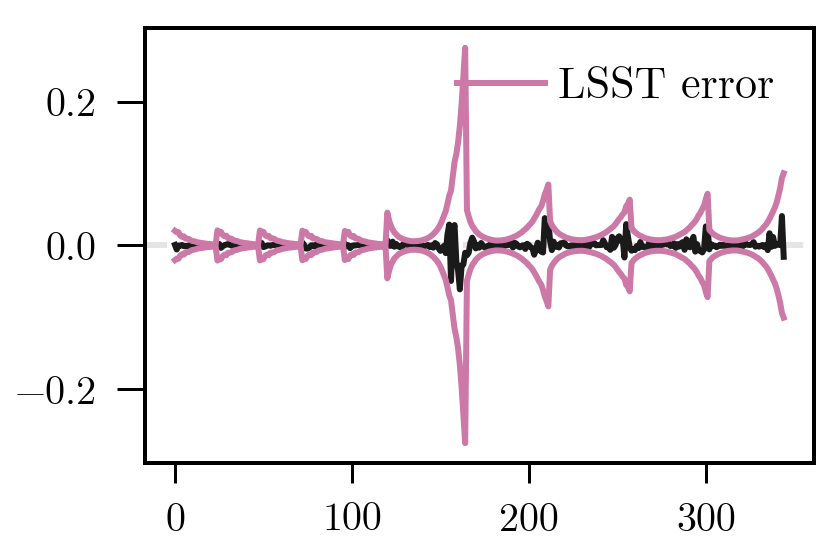

In [10]:
test_model = 1
x, y = combo.get_realizations(model_index=1, verbose=True)
y_true = np.mean(y, axis=0)

plt.axhline(0.0, color=(0,0,0,0.1), ls='dashed')

ys, sigs = combo.GP(combo.params.T[1])
# plt.fill_between( x, (sigs/y_true), (-sigs/y_true), color=default_color_list[3], alpha=0.2)

# plt.plot(ys)
plt.plot( (ys-y_true)/y_true, '-')

invcov = combo.compute_cov(0)
cov = np.linalg.inv(invcov)
plt.plot( np.sqrt(np.diag(cov))/y_true, label='LSST error', color=default_color_list[4] )
plt.plot( -np.sqrt(np.diag(cov))/y_true, color=default_color_list[4] )

plt.legend()
# plt.ylim(-0.02, 0.02)

In [11]:
combo.likelihood([0.1,0.3,2.1])

-7.454414834256774

In [12]:
# set up some constants for prior evaluation
m_nu_min = 0.06  # minimum from oscillation experiments
m_nu_max = 2*np.max(combo.table['M_nu(eV)'])
om_m_min = np.min(combo.table['Omega_m'])
om_m_max = 2*np.max(combo.table['Omega_m'])
A_s_min = np.min(combo.table['10^9*A_s'])
A_s_max = 2*np.max(combo.table['10^9*A_s'])

In [13]:

# define emcee function calls, prior, likelihood,
def lnprior(theta):
    """Ensure the sampler stays near computed simulations."""
    m_nu, om_m, A_s = theta
    if (m_nu_min < m_nu < m_nu_max and
            om_m_min < om_m < om_m_max and
            A_s_min < A_s < A_s_max):
        return 0.0
    return -np.inf


def lnlike(theta):
    """Compute the log likelihood based on multivariate Gaussian."""
    return combo.likelihood(theta)


def lnprob(theta):
    """Combine the likelihood and prior."""
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)


In [ ]:

import emcee

# set up emcee
ndim, nwalkers = 3, 64
p0 = [combo.params.T[1] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# begin sampling, use incremental chain
filename = 'combo12.out'
f = open(filename, "w")
f.close()

for result in sampler.sample(p0, iterations=5000, storechain=False):
    position = result[0]
    f = open(filename, "a")
    for k in range(position.shape[0]):
        out_str = "{0:4d} {1:s}\n".format(k, ' '.join(map(str, position[k])))
        f.write(out_str)
    f.close()


/home/zequnl/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [ ]:
# gp_test = combo.gp_list[6]

In [ ]:
# # set up 2D grid
# xx1 = np.linspace(-4,4,50)
# xx2 = np.linspace(-4,4,50)
# x, y = np.meshgrid(xx1,xx2)

# z = np.zeros((len(xx1),len(xx2)))
# for i in range(len(xx1)):
#     for j in range(len(xx2)):
#         z[i,j] = gp_test.log_marginal_likelihood(np.array([-0.72435124,  x[i,j], y[i,j],  1.32159915]))
        
# plt.imshow(z, extent=(-4,4,-4,4), origin='lower', vmin=-100)
# plt.colorbar()

In [ ]:
# gp_test.kernel_